In [214]:
import dotenv
dotenv.load_dotenv()

True

In [215]:
from langchain.utilities.tavily_search import TavilySearchAPIWrapper
from langchain.tools.tavily_search import TavilySearchResults

tavily_tool = TavilySearchResults(api_wrapper=TavilySearchAPIWrapper())


from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper

wikipedia = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())

available_tools = [tavily_tool, wikipedia]
# wikipedia

In [216]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(temperature=0)

In [217]:

members = {
    "MarketExpert":"Market expert in london regarding rental and on-sale properties in a real estate consultancy.", 
    "LocationExpert":"Location expert and strategist in london in a real estate consultancy", 
    "FinanceExpert":"Financial Expert in London in a real estate consultancy",
    # "CompanyHead": "You're head of a real estate consultancy "
}


In [218]:

from langchain_core.pydantic_v1 import BaseModel, Field, validator
from langchain_core.output_parsers import PydanticOutputParser, JsonOutputParser
from langchain.prompts import PromptTemplate
from langchain_core.messages import SystemMessage, AIMessage


class Questions(BaseModel):
    questionList: List[str]

questions_list_parser = JsonOutputParser(pydantic_object=Questions)

def supervise_expert(member_name, member_info):
    prompt_to_head_string = (
        "You are a head of a real estate company. "
        "User Asks the following: \n```\n{query}\n```\n"
        "Based on the user query, give five to ten question to ask our {member_name}, "
        "{member_info} \n"
        "Make sure you ask the expert the questions based on his/her expertise."
        "Make sure to include the context in the question, since the experts arent aware of the context. "
        "\n{format_instructions}"
    )
    prompt_to_head = PromptTemplate(
        template=prompt_to_head_string,
        input_variables=["query"],
        partial_variables={
            "member_info":member_info, 
            "member_name":member_name, 
            "format_instructions":questions_list_parser.get_format_instructions()
        }
    )
    query_generation_chain = prompt_to_head | llm | questions_list_parser
    return query_generation_chain
    pass


e = 'MarketExpert'
market_expert_qchain = supervise_expert(e, members[e])


e = 'FinanceExpert'
finance_expert_qchain = supervise_expert(e, members[e])

e = 'LocationExpert'
location_expert_qchain = supervise_expert(e, members[e])

def market_expert_questioning_node(state):
    
    m_exp_quests = market_expert_qchain.invoke(dict(query=state['user_query']))['questionList']
    for q in m_exp_quests:
        state['unsolved_questions'].append({'askto': "MarketExpert", "question": q})
    return state
def finance_expert_questioning_node(state):
    m_exp_quests = finance_expert_qchain.invoke(dict(query=state['user_query']))['questionList']
    for q in m_exp_quests:
        state['unsolved_questions'].append({'askto': "FinanceExpert", "question": q})
    return state

def location_expert_questioning_node(state):
    m_exp_quests = location_expert_qchain.invoke(dict(query=state['user_query']))['questionList']
    for q in m_exp_quests:
        state['unsolved_questions'].append({'askto': "LocationExpert", "question": q})
    return state




In [219]:
from langchain.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.agents.output_parsers.openai_tools import OpenAIToolsAgentOutputParser
from langchain.agents import AgentExecutor, create_openai_tools_agent

from langchain.agents.format_scratchpad.openai_tools import (
    format_to_openai_tool_messages,
)

def create_answering_expert(tools, role, role_description):

    sys_prompt_str = ("You're an expert of a real estate consultancy. "+
            "Your expertise is "+role+" (Description: "+role_description+"). ")
    
    prompt_str = (
        "You're asked the following by the head of the consultancy. \n"
        "{input}\n"
        "Based on the query, give a short and concise answer, two or three sentences in plain readable text. "
        "Use Tools if necessary. "
    )
    sprompt = ChatPromptTemplate.from_messages([
        (
            "system", sys_prompt_str
        ),
        ("user", prompt_str),
        MessagesPlaceholder(variable_name="agent_scratchpad")
    ])
    llm_with_tools = llm.bind_tools(tools)
    agent = (
                {
                    "input": lambda x: x["input"],
                    "agent_scratchpad": lambda x: format_to_openai_tool_messages(
                        x["intermediate_steps"]
                    ),
                }
                | sprompt
                | llm_with_tools
                | OpenAIToolsAgentOutputParser()
            )
    agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=False)
    return agent_executor


e = "FinanceExpert"
market_expert = create_answering_expert(available_tools, e, members[e])
def market_expert_node(state):
    lq = state['unsolved_questions'][0]
    state['unsolved_questions'] = state['unsolved_questions'][1:]
    outp = market_expert.invoke(dict(input=lq['question']))['output']
    state['solved_questions'].append((
        lq['askto'],
        lq['question'],
        outp
    ))
    return state


e = "FinanceExpert"
finance_expert = create_answering_expert(available_tools, e, members[e])
def finance_expert_node(state):
    lq = state['unsolved_questions'][0]
    state['unsolved_questions'] = state['unsolved_questions'][1:]
    outp = finance_expert.invoke(dict(input=lq['question']))['output']
    state['solved_questions'].append((
        lq['askto'],
        lq['question'],
        outp
    ))
    return state


e = "LocationExpert"
location_expert = create_answering_expert(available_tools, e, members[e])
def location_expert_node(state):
    lq = state['unsolved_questions'][0]
    state['unsolved_questions'] = state['unsolved_questions'][1:]
    outp = market_expert.invoke(dict(input=lq['question']))['output']
    state['solved_questions'].append((
        lq['askto'],
        lq['question'],
        outp
    ))
    return state

In [220]:


processing_prompt_template = (
    "```plain_text\n{summary}\n```\n"
    "Based on the above expert's QnA, respond the following client's query. Make sure you conclude with concise reasoning. \n"
    "{client_query}"
)
processing_prompt = PromptTemplate.from_template(processing_prompt_template)
process_expert_chain = processing_prompt | llm



qa_mapping_to_prompt = lambda q: "\n\n".join(["Question: "+i[1]+"\nAnswer: "+i[2] for i in q])
    
def process_expert_responses(state):
    summary_mapping = qa_mapping_to_prompt(state['solved_questions'])
    respo = process_expert_chain.invoke(dict(summary=summary_mapping, client_query=state['user_query'])).content
    return dict(model_response=respo)


In [249]:
import concurrent.futures

def run_in_parallel(datalist, function_name):
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = [executor.submit(function_name, index, datalist) for index in range(len(datalist))]
        results = [future.result() for future in concurrent.futures.as_completed(futures)]
    return results

# Run the function
# results = run_in_parallel(datalist)

In [250]:
from typing import TypedDict, List

class AppState(TypedDict):
    unsolved_questions: List
    solved_questions: List
    model_response: str
    what_next: str
    user_query: str
    
    qa_list:List
    


def ask_question(index, qlist):
    resp = None
    if qlist[index]['askto'] == "MarketExpert":
        resp = market_expert.invoke(dict(input=qlist[index]['question']))['output']
    if qlist[index]['askto'] == "FinanceExpert":
        resp = finance_expert.invoke(dict(input=qlist[index]['question']))['output']
    if qlist[index]['askto'] == "LocationExpert":
        resp = location_expert.invoke(dict(input=qlist[index]['question']))['output']
    qlist[index] = (
            qlist[index]['askto'],
            qlist[index]['question'],
            resp
        )
    return
    

def answer_gen_parallel_node(state):
    state['qa_list'] = state['unsolved_questions'].copy()
    run_in_parallel(state['qa_list'], ask_question)
    state['solved_questions'] = state['qa_list'].copy()
    pass


def answer_gen_node(state):
    if len(state['unsolved_questions']) == 0:
        return dict(what_next="_continue_")
    return dict(what_next="askQuestionTo"+state['unsolved_questions'][0]['askto'])

In [251]:
def initialize(state):
    return {'original_query': state['user_query']}

In [252]:
from langgraph.graph import StateGraph, START, END

In [253]:
workflow = StateGraph(AppState)

workflow.add_node("market_expert_questioning_node", market_expert_questioning_node)
workflow.add_edge(START, "market_expert_questioning_node")

workflow.add_node("finance_expert_questioning_node", finance_expert_questioning_node)
workflow.add_edge("market_expert_questioning_node","finance_expert_questioning_node")

workflow.add_node("location_expert_questioning_node", location_expert_questioning_node)
workflow.add_edge("finance_expert_questioning_node","location_expert_questioning_node")




workflow.add_node("answer_gen_parallel_node", answer_gen_parallel_node)
workflow.add_edge("location_expert_questioning_node", "answer_gen_parallel_node")



# workflow.add_node("MarketExpert", market_expert_node)
# workflow.add_node("FinanceExpert", finance_expert_node)
# workflow.add_node("LocationExpert", location_expert_node)


# workflow.add_edge("MarketExpert", "answer_gen_node")
# workflow.add_edge("FinanceExpert", "answer_gen_node")
# workflow.add_edge("LocationExpert", "answer_gen_node")


workflow.add_node("process_expert_responses", process_expert_responses)
workflow.add_edge("answer_gen_parallel_node", "process_expert_responses")


workflow.add_edge("process_expert_responses", END)

# workflow.add_conditional_edges("answer_gen_node", lambda x: x['what_next'], dict(
#     _continue_="process_expert_responses",
#     askQuestionToMarketExpert="MarketExpert",
#     askQuestionToFinanceExpert="FinanceExpert",
#     askQuestionToLocationExpert="LocationExpert",
# ))




consultation_app = workflow.compile()



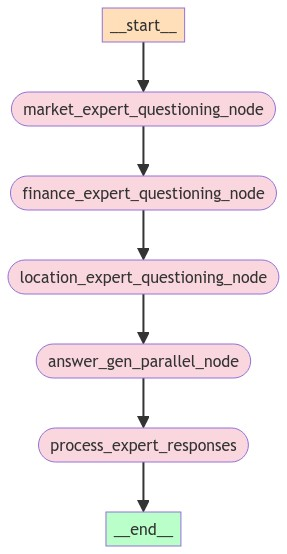

In [254]:
from IPython.display import Image, display

display(Image(consultation_app.get_graph(xray=True).draw_mermaid_png()))

In [255]:
resp = consultation_app.invoke(dict(
    user_query="How does the annual events and cultural scene in London impact the real estate prospects in the city?",
    unsolved_questions=[],
    solved_questions=[]
    
), config=dict(recursion_limit=200))
resp


{'unsolved_questions': [{'askto': 'MarketExpert',
   'question': 'How do annual events in London such as the Notting Hill Carnival impact rental prices in the surrounding areas?'},
  {'askto': 'MarketExpert',
   'question': 'In what ways does the cultural scene in London influence the demand for luxury properties in the city?'},
  {'askto': 'MarketExpert',
   'question': 'Are there specific neighborhoods in London that see a surge in property sales during major cultural events?'},
  {'askto': 'MarketExpert',
   'question': 'Do certain cultural events in London attract more international buyers to the real estate market?'},
  {'askto': 'MarketExpert',
   'question': 'How does the annual cultural calendar in London affect the rental yields for buy-to-let investors?'},
  {'askto': 'MarketExpert',
   'question': 'Are there any trends in property prices linked to specific cultural festivals or events in London?'},
  {'askto': 'MarketExpert',
   'question': 'Do cultural events like the Londo

In [256]:
resp['model_response']

"The annual events and cultural scene in London have a significant impact on real estate prospects in the city. These events attract tourists, investors, and residents, leading to increased demand for properties in the area. The cultural vibrancy of London also enhances the city's overall appeal, making it a desirable location for both domestic and international buyers. As a result, real estate prices tend to be higher in areas with a strong cultural scene and frequent events. In conclusion, the annual events and cultural scene in London play a crucial role in driving real estate prospects by boosting demand and property values."